# Socratic Models for Multimodal Reasoning
## Introduction
In this notebook, we use the Socratic models approach applied to multimodal reasoning tasks, i.e, chain-of-thought (CoT) reasoning & visual question-answering (VQA)

### Imports

In [1]:

# global
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from transformers import set_seed
import openai
from datasets import load_dataset

# local 
sys.path.insert(0, '../')
import scripts.image_captioning as ic
from scripts.utils import get_device
# extensions
%load_ext autoreload
%autoreload 2

/opt/conda/envs/dl2-sm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Set seed & device

In [2]:
set_seed(42)    # set seed for reproducibility
# set the device to use
device = get_device()
print(f'Using device: {device}')

Using device: cuda


#### Class instantiation

In [3]:
# instantiate managers
clip_manager = ic.ClipManager(device=device)
image_manager = ic.ImageManager()
vocab_manager = ic.VocabManager()
lm_manager = ic.LmManager(version='google/flan-t5-xxl', use_api=True, device=device)
openai.api_key = os.getenv('OPENAI_API_KEY')
prompt_generator = ic.LmPromptGenerator()

#### Create image & text embeddings

In [5]:
# compute place & objects features
place_feats = clip_manager.get_text_emb([f'Photo of a {p}.' for p in vocab_manager.place_list])
obj_feats = clip_manager.get_text_emb([f'Photo of a {o}.' for o in vocab_manager.object_list])

## Chain-of-thought reasoning
### Data
We use the [ScienceQA](https://scienceqa.github.io/) dataset.

In [6]:
# load scienceQA dataset
scienceQA_dataset = load_dataset('derek-thomas/ScienceQA', split='validation')
# filter out samples with no image
scienceQA_dataset = [sample for sample in scienceQA_dataset if sample['image'] is not None]

Found cached dataset parquet (/home/neil/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


#### Show samples

In [ ]:
# show samples
# CoT samples: 68, 90, 122, 142, 155, 167, 177, 191, 202, 227, 234, 236, 254, 325, 340
# VQA samples: 135, 140, 148, 155, 177, 202, 215, 223, 227, 234, 236, 237, 254, 257, 301, 307, 310, 311, 316, 319, 320, 324, 325, 327, 331, 334, 342, 348
for i, sample in enumerate(scienceQA_dataset[340:350]):
    print(f'sample {i}:')
    plt.figure(figsize=(5, 5))
    plt.imshow(sample['image'])
    plt.axis('off')
    plt.show()
    # sample['image'].show()
    print('question:', sample['question'])
    print('choices:', sample['choices'])
    print('hint:', sample['hint'])
    # print('lecture:', sample['lecture'])
    print('answer:', sample['answer'])
    print('solution:', sample['solution'])
    print('-'*50)

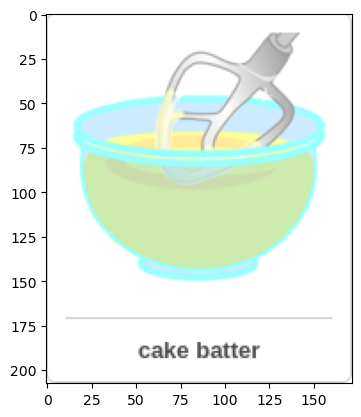

question: Which property matches this object?
choices: ['sweet', 'bouncy']
answer: 0
solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.


In [7]:
# select & viz sample
sample_idx = 122
sample = scienceQA_dataset[sample_idx]
# show sample
# plt.figure(figsize=(5, 5))
plt.imshow(sample['image'])
# plt.axis('off')
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

### Zero-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with a sentence to induce zero-shot CoT reasoning. Generate outputs (solution + rationale) from LM.

In [ ]:
# generate n outputs from LM using prompt
num_outputs = 3

# compose prompt
prompt = prompt_generator.create_cot_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

In [28]:
# gpt
def get_response_gpt(prompt, model='gpt-3.5-turbo', **kwargs):
    response = openai.ChatCompletion.create(model=model, messages = [
        {"role": "user", "content": prompt}
    ], **kwargs)
    output = response['choices'][0]['message']['content']
    return output

# generate outputs from LM
# lm_params = {"min_new_tokens": 5, "max_new_tokens": 50, "length_penalty": 2, "num_beams": 8, "no_repeat_ngram_size": 3, "temperature": 0.9,  "early_stopping": True, "do_sample": True, "num_return_sequences": 1}
# outputs = lm_manager.generate_response([prompt] * num_outputs, lm_params)
# for i, output in enumerate(outputs):
    # print(f'{i + 1}. {output}')
output = get_response_gpt(prompt, temperature=1., max_tokens=100)
print(f'output: {output}')
    
print(f'\ngt solution: {sample["solution"]}\ngt answer: {sample["answer"]}')

output: Based on the objects listed, none of them suggest a property of "bouncy." The closest property that could match would be "sweet," which could describe the batter or fondant. Therefore, the answer is "sweet."

gt solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.
gt answer: 0


### Few-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with previous prompts & solutions (rational + choice) to induce few-shot CoT reasoning. Generate outputs from LM.

example sample:


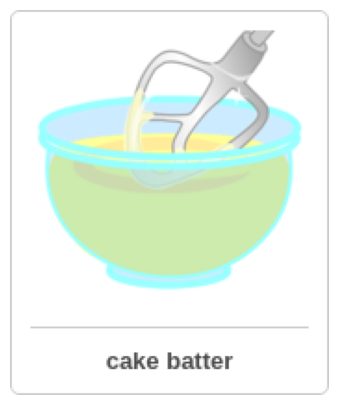

question: Which property matches this object?
choices: ['sweet', 'bouncy']
answer: 0
solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.
target sample:


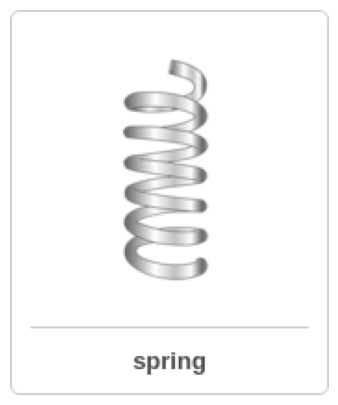

question: Which property matches this object?
choices: ['flexible', 'slippery']
answer: 0
solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.


In [29]:
# select & viz example & target samples
# candidate pairs: single-prop: 122, 142 | multi-prop: 340, 142, 
# sample example
eg_sample_idx, target_sample_idx = 122, 142
eg_sample, target_sample = scienceQA_dataset[eg_sample_idx], scienceQA_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(5, 5))
plt.imshow(eg_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}\nsolution: {eg_sample["solution"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(5, 5))
plt.imshow(target_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\nsolution: {target_sample["solution"]}')

In [30]:
prompt = prompt_generator.create_cot_prompt(eg_sample, clip_manager, vocab_manager, place_feats, obj_feats) + f'{eg_sample["solution"]}. So the answer is {eg_sample["choices"][eg_sample["answer"]]}\n' + prompt_generator.create_cot_prompt(target_sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a kitchen. It contains a clabber, eggbeater, blender, whipping cream, batter, fondant, contrivance, gismo, widget, sifter.
Question: Which property matches this object?
Choices: ['sweet', 'bouncy']
Answer: Let's think step by step...Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.. So the answer is sweet
This image was taken in a drugstore. It contains a spring, spring scale, coil, volute, sprig, set gun, whipping cream, elastic, spar, whisk.
Question: Which property matches this object?
Choices: ['flexible', 'slippery']
Answer: Let's think step by step...



In [33]:
# generate outputs from LM
# outputs = lm_manager.generate_response([prompt] * num_outputs, lm_params)
# for i, output in enumerate(outputs):
    # print(f'{i + 1}. {output}')
output = get_response_gpt(prompt, temperature=1., max_tokens=100)
print(f'output: {output}')
print(f'\ngt solution: {sample["solution"]}\ngt answer: {target_sample["answer"]}')

output: Look at the object.
Think about each property.
Something that is flexible can bend without breaking. Springs and coils are flexible, so is the elastic.
Something that is slippery is smooth and difficult to hold or grip. None of these objects in the image have a slippery property. 
So the answer is flexible.

gt solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.
gt answer: 0


### Zero-shot VQA
Zero-shot visual question-answering using VLM (CLIP + LM)

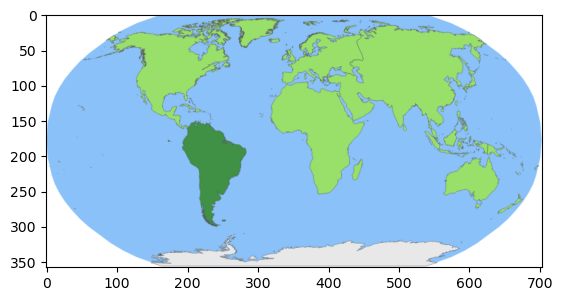

question: Which continent is highlighted?
choices: ['South America', 'Antarctica', 'North America']
answer: 0
solution: This continent is South America.


In [34]:
# get sample
# VQA samples: 134, 140, 148, 155, 177, 202, 215, 223, 227, 234, 236, 237, 254, 257
sample_idx = 134
sample = scienceQA_dataset[sample_idx]
# show sample
# plt.figure(figsize=(5, 5))
plt.imshow(sample['image'])
# plt.axis('off')
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

In [35]:
# generate n outputs from LM using prompt
num_outputs = 5

# compose prompt
prompt = prompt_generator.create_vqa_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

# generate outputs from LM
# outputs = lm_manager.generate_response([prompt] * num_outputs, lm_params)
# for i, output in enumerate(outputs):
    # print(f'{i + 1}. {output}')
output = get_response_gpt(prompt, temperature=1., max_tokens=100)
print(f'output: {output}')
    
print(f'\ngt answer: {sample["answer"]}')

prompt: This image was taken in a rainforest. It contains a Latin American, part, tennis ball, unit, geographical point, caranday, caranda palm, Copernicia australis, asclepiad, horseshoe. Using this information, answer the following question: Which continent is highlighted?
        Choices: ['South America', 'Antarctica', 'North America']
        Answer: 

output: South America

gt answer: 0


## Evaluation
### Zero-shot CoTR

In [ ]:
# choose n random samples from dataset
num_samples = 5  # number of samples to choose
num_outputs = 1   # number of outputs to generate from LM
np.random.seed(42)
sample_idxs = np.random.choice(len(scienceQA_dataset), num_samples, replace=False)
samples = [scienceQA_dataset[idx] for idx in sample_idxs]
accs = []
for sample in samples:
    prompt = prompt_generator.create_cot_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
    outputs = lm_manager.generate_response([prompt] * num_outputs, lm_params)
    acc = int(sample['choices'][sample['answer']] == outputs[0])
    accs.append(acc)
print(f'avg acc of zero-shot CoTR over {num_samples} samples: {np.mean(accs)*100:.2f}%')

### Few-shot CoTR

In [ ]:
# choose example sample
eg_sample_idx = 122
# choose n random samples from dataset
num_samples = 5  # number of samples to choose
num_outputs = 1   # number of outputs to generate from LM
np.random.seed(42)
sample_idxs = np.random.choice(len(scienceQA_dataset), num_samples, replace=False)
samples = [scienceQA_dataset[idx] for idx in sample_idxs]
accs = []
for sample in samples:
    prompt = prompt_generator.create_cot_prompt(eg_sample, clip_manager, vocab_manager, place_feats, obj_feats) + f'{eg_sample["solution"]}. So the answer is {eg_sample["choices"][eg_sample["answer"]]}\n' + prompt_generator.create_cot_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
    outputs = lm_manager.generate_response([prompt] * num_outputs, lm_params)
    acc = int(sample['choices'][sample['answer']] == outputs[0])
    accs.append(acc)
print(f'avg acc of few-shot CoTR over {num_samples} samples: {np.mean(accs)*100:.2f}%')

### VQA

In [ ]:
# choose n random samples from dataset
num_samples = 5  # number of samples to choose
num_outputs = 1   # number of outputs to generate from LM
np.random.seed(42)
sample_idxs = np.random.choice(len(scienceQA_dataset), num_samples, replace=False)
samples = [scienceQA_dataset[idx] for idx in sample_idxs]
accs = []
for sample in samples:
    prompt = prompt_generator.create_vqa_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
    outputs = lm_manager.generate_response([prompt] * num_outputs, lm_params)
    acc = int(sample['choices'][sample['answer']] == outputs[0])
    accs.append(acc)
print(f'avg acc of zero-shot VQA over {num_samples} samples: {np.mean(accs)*100:.2f}%')